In [1]:
from darts.datasets import *
from darts.models.forecasting.pl_forecasting_module import (
    PLPastCovariatesModule,
    io_processor,)
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from darts.dataprocessing.transformers import BoxCox, Scaler

from darts.models.forecasting.torch_forecasting_model import PastCovariatesTorchModel
import torch
import torch.nn as nn

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
series = ElectricityConsumptionZurichDataset().load()

<Axes: xlabel='Timestamp'>

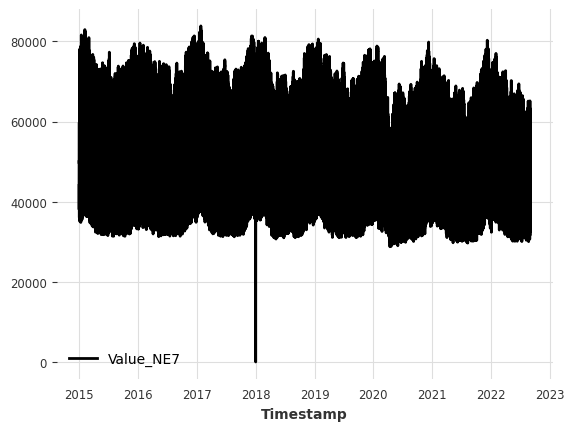

In [3]:
series['Value_NE7'].plot()

In [17]:
class _BaseModule(PLPastCovariatesModule):
    def __init__(self, input_size, hidden_size, output_size, nr_params :int,  **kwargs):
        super().__init__(**kwargs)
        self.hidden = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
        self.input_size = input_size
        self.target_size = output_size
        self.nr_params = nr_params
        self.target_length = self.output_chunk_length
    @io_processor
    def forward(self, x_in : tuple):
        data, _  = x_in
        print("shape 1 : ", data.shape)
        data = data.permute(1, 0, 2)
        data = self.hidden(data)
        data = self.activation(data)
        out = self.output(data)
        print("shape 2 : ", out.shape)
        predictions = out
        predictions = predictions.view(
            -1, self.target_length, self.target_size, self.nr_params
        )
        print("shape 3 : ", predictions.shape)
        return predictions

In [18]:
class BaseModel(PastCovariatesTorchModel):
    def __init__(
        self,
        input_chunk_length: int,
        output_chunk_length: int,
        hidden_size : int = 12024, 
        output_chunk_shift: int = 0,
        **kwargs):

        super().__init__(**self._extract_torch_model_params(**self.model_params))

        # extract pytorch lightning module kwargs
        self.pl_module_params = self._extract_pl_module_params(**self.model_params)
        self.hidden_size = hidden_size
    @property
    def supports_multivariate(self) -> bool:
        return True
    def _create_model(self, train_sample: tuple[torch.Tensor]) -> torch.nn.Module:
        # samples are made of (past_target, past_covariates, future_target)
        input_dim = train_sample[0].shape[1] + (
            train_sample[1].shape[1] if train_sample[1] is not None else 0
        )
        output_dim = train_sample[-1].shape[1]
        nr_params = 1 if self.likelihood is None else self.likelihood.num_parameters

        return _BaseModule(
            input_size=input_dim,
            output_size=output_dim,
            hidden_size=self.hidden_size,
            nr_params=nr_params,
            **self.pl_module_params,
        )


In [4]:
target = series['Value_NE5'][:1000]

In [19]:
model = BaseModel(input_chunk_length=4*24, output_chunk_length=4*24, hidden_size=2048, n_epochs = 10)

In [20]:
model.fit(target)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_criterion | MSELoss          | 0     
2 | val_criterion   | MSELoss          | 0     
3 | train_metrics   | MetricCollection | 0     
4 | val_metrics     | MetricCollection | 0     
5 | hidden          | Linear           | 4.1 K 
6 | activation      | ReLU             | 0     
7 | output          | Linear           | 2.0 K 
-----------------------------------------------------
6.1 K     Trainable params
0         Non-trainable params
6.1 K     Total params
0.025     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 9

`Trainer.fit` stopped: `max_epochs=10` reached.


shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 9

BaseModel(hidden_size=2048, output_chunk_shift=0, input_chunk_length=96, output_chunk_length=96, n_epochs=10)

In [21]:
pred = model.predict(24*6)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

shape 1 :  torch.Size([1, 96, 1])
shape 2 :  torch.Size([96, 1, 1])
shape 3 :  torch.Size([1, 96, 1, 1])
shape 1 :  torch.Size([1, 96, 1])
shape 2 :  torch.Size([96, 1, 1])
shape 3 :  torch.Size([1, 96, 1, 1])


<Axes: xlabel='Timestamp'>

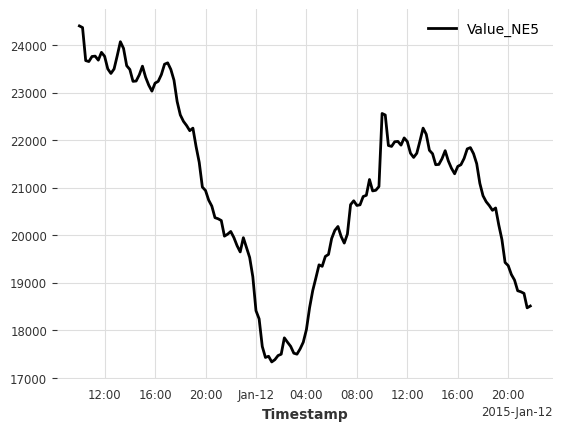

In [11]:
pred.plot()

In [4]:
__all__ = ['PatchTST']

# Cell
from typing import Callable, Optional
import torch
from torch import nn
from torch import Tensor
import torch.nn.functional as F
import numpy as np

from layers.PatchTST_backbone import PatchTST_backbone
from layers.PatchTST_layers import series_decomp
from darts.models.forecasting.pl_forecasting_module import (
    PLPastCovariatesModule,
    io_processor,)


class Model(PLPastCovariatesModule):
    def __init__(self, configs, input_size : int , output_size : int,  max_seq_len: Optional[int] = 1024, d_k: Optional[int] = None, d_v: Optional[int] = None, norm: str = 'BatchNorm', attn_dropout: float = 0.,
                 act: str = "gelu", key_padding_mask: bool = 'auto', padding_var: Optional[int] = None, attn_mask: Optional[Tensor] = None, res_attention: bool = True,
                 pre_norm: bool = False, store_attn: bool = False, pe: str = 'zeros', learn_pe: bool = True, pretrain_head: bool = False, head_type='flatten', verbose: bool = False, nr_params : int = 1, **kwargs):

        super().__init__(**kwargs)

        # load parameters
        c_in = configs.enc_in
        context_window = configs.seq_len
        target_window = configs.pred_len

        n_layers = configs.e_layers
        n_heads = configs.n_heads
        d_model = configs.d_model
        d_ff = configs.d_ff
        dropout = configs.dropout
        fc_dropout = configs.fc_dropout
        head_dropout = configs.head_dropout

        individual = configs.individual

        patch_len = configs.patch_len
        stride = configs.stride
        padding_patch = configs.padding_patch

        revin = configs.revin
        affine = configs.affine
        subtract_last = configs.subtract_last

        decomposition = configs.decomposition
        kernel_size = configs.kernel_size
        self.input_size = input_size
        self.target_size = output_size
        self.nr_params = nr_params
        self.target_length = self.output_chunk_length
        # model
        self.decomposition = decomposition
        if self.decomposition:
            self.decomp_module = series_decomp(kernel_size)
            self.model_trend = PatchTST_backbone(c_in=c_in, context_window=context_window, target_window=target_window, patch_len=patch_len, stride=stride,
                                                 max_seq_len=max_seq_len, n_layers=n_layers, d_model=d_model,
                                                 n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout,
                                                 dropout=dropout, act=act, key_padding_mask=key_padding_mask, padding_var=padding_var,
                                                 attn_mask=attn_mask, res_attention=res_attention, pre_norm=pre_norm, store_attn=store_attn,
                                                 pe=pe, learn_pe=learn_pe, fc_dropout=fc_dropout, head_dropout=head_dropout, padding_patch=padding_patch,
                                                 pretrain_head=pretrain_head, head_type=head_type, individual=individual, revin=revin, affine=affine,
                                                 subtract_last=subtract_last, verbose=verbose, **kwargs)
            self.model_res = PatchTST_backbone(c_in=c_in, context_window=context_window, target_window=target_window, patch_len=patch_len, stride=stride,
                                               max_seq_len=max_seq_len, n_layers=n_layers, d_model=d_model,
                                               n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout,
                                               dropout=dropout, act=act, key_padding_mask=key_padding_mask, padding_var=padding_var,
                                               attn_mask=attn_mask, res_attention=res_attention, pre_norm=pre_norm, store_attn=store_attn,
                                               pe=pe, learn_pe=learn_pe, fc_dropout=fc_dropout, head_dropout=head_dropout, padding_patch=padding_patch,
                                               pretrain_head=pretrain_head, head_type=head_type, individual=individual, revin=revin, affine=affine,
                                               subtract_last=subtract_last, verbose=verbose, **kwargs)
        else:
            self.model = PatchTST_backbone(c_in=c_in, context_window=context_window, target_window=target_window, patch_len=patch_len, stride=stride,
                                           max_seq_len=max_seq_len, n_layers=n_layers, d_model=d_model,
                                           n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout,
                                           dropout=dropout, act=act, key_padding_mask=key_padding_mask, padding_var=padding_var,
                                           attn_mask=attn_mask, res_attention=res_attention, pre_norm=pre_norm, store_attn=store_attn,
                                           pe=pe, learn_pe=learn_pe, fc_dropout=fc_dropout, head_dropout=head_dropout, padding_patch=padding_patch,
                                           pretrain_head=pretrain_head, head_type=head_type, individual=individual, revin=revin, affine=affine,
                                           subtract_last=subtract_last, verbose=verbose, **kwargs)

    def forward(self, x_in):
        x, _ = x_in          # x: [Batch, Input length, Channel]
        print("size", x.size())
        if self.decomposition:
            res_init, trend_init = self.decomp_module(x)
            print("res_init : ", res_init.shape)
            print("trend_init :", trend_init.shape)
            res_init, trend_init = res_init.permute(0, 2, 1), trend_init.permute(
                0, 2, 1)  # x: [Batch, Channel, Input length]
            res = self.model_res(res_init)
            trend = self.model_trend(trend_init)
            x = res + trend
            print(x)
            x = x.permute(0, 2, 1)
            predictions = x
            print("shape 4 :", predictions.shape)
            predictions = predictions.view(
            -1, self.target_length, self.target_size, self.nr_params
        )
            print("shape 5 :", predictions.shape)    # x: [Batch, Input length, Channel]
        else:
            x = x.permute(0, 2, 1)    # x: [Batch, Channel, Input length]
            x = self.model(x)
            x = x.permute(0, 2, 1)
            predictions = x
            predictions = predictions.view(
            -1, self.target_length, self.target_size, self.nr_params
        )




        return predictions  
            



In [17]:
from darts.models.forecasting.torch_forecasting_model import PastCovariatesTorchModel
# Adjust this import based on your environment
import torch

from dataclasses import dataclass
from darts.models.forecasting.pl_forecasting_module import PLForecastingModule
import inspect


@dataclass
class Config:
    enc_in: int
    seq_len: int
    pred_len: int
    e_layers: int
    n_heads: int
    d_model: int
    d_ff: int
    fc_dropout: float
    dropout: float
    head_dropout: float
    individual: int
    patch_len: int
    stride: int
    padding_patch: str
    revin: int
    affine: int
    subtract_last: int
    decomposition: int
    kernel_size: int


class PatchTSTModel(PastCovariatesTorchModel):
    def __init__(self,
                 input_chunk_length: int,
                 output_chunk_length: int,
                 output_chunk_shift: int = 0,
                 enc_in: int = 7,
                 n_layers: int = 8,
                 n_heads: int = 8,
                 d_model: int = 512,
                 d_ff: int = 2048,
                 fc_dropout: float = 0.05,
                 dropout: float = 0.05,
                 head_dropout: float = 0,
                 individual: int = 0,
                 patch_len: int = 16,
                 stride: int = 8,
                 padding_patch='end',
                 revin: int = 0,
                 affine: int = 0,
                 subtract_last: int = 0,
                 decomposition: int = 0,
                 kernel_size: int = 25,

                 **kwargs):
        """
        PatchTST implementation with PastCovariatesTorchModel integration.

        Parameters:
        - input_size: Length of the input window (look-back period).
        - patch_len: Length of each patch (default: 16).
        - stride: Stride between patches (default: 8).
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
        - num_layers: Number of Transformer layers (default: 2).
        - dropout: Dropout probability (default: 0.1).
        - output_chunk_length: Number of time steps to predict.
        - lr: Learning rate.
        - batch_size: Batch size during training.
        - kwargs: Additional arguments for the PastCovariatesTorchModel.
        """
        self._configs = Config(enc_in=enc_in, seq_len=input_chunk_length, pred_len=output_chunk_length, e_layers=n_layers, n_heads=n_heads, d_model=d_model, d_ff=d_ff, fc_dropout=fc_dropout, dropout=dropout, head_dropout=head_dropout,
                               individual=individual, patch_len=patch_len, stride=stride, padding_patch=padding_patch, revin=revin, affine=affine, subtract_last=subtract_last, decomposition=decomposition, kernel_size=kernel_size)

        # Initialize the base class
        super().__init__(**self._extract_torch_model_params(**self.model_params))
        self.pl_module_params = self._extract_pl_module_params(**self.model_params)


    @property
    def supports_multivariate(self) -> bool:
        return True

    def _create_model(self, train_sample: tuple[torch.Tensor]) -> torch.nn.Module:
        """
        Creates and returns the PatchTST model.

        Parameters:
        - input_dim: The number of input features (dimensions of the input time series).
        - output_dim: The number of output features (dimensions of the output time series).
        """
        input_dim = train_sample[0].shape[1] + (
            train_sample[1].shape[1] if train_sample[1] is not None else 0
        )
        output_dim = train_sample[-1].shape[1]
        nr_params = 1 if self.likelihood is None else self.likelihood.num_parameters
        return Model(
            configs=self._configs, input_size = input_dim,   output_size = output_dim, nr_params=nr_params, **self.pl_module_params
        )

In [39]:
model = PatchTSTModel(output_chunk_length =  4*24, input_chunk_length =  4*24, n_epochs=5)

In [5]:
target = series['Value_NE5'][:10000]
target_long = series['Value_NE5'][:20000]
val = series['Value_NE5'][10000: 15000]

In [6]:
scaler_type = StandardScaler()
scaler = Scaler(scaler=scaler_type, global_fit=True)
target_scaled = scaler.fit_transform(target)
target_long_scaled = scaler.transform(target_long)
val_scaled = scaler.transform(val)

In [41]:
model.fit(target_scaled, val_series=val_scaled, )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params
------------------------------------------------------
0 | criterion       | MSELoss           | 0     
1 | train_criterion | MSELoss           | 0     
2 | val_criterion   | MSELoss           | 0     
3 | train_metrics   | MetricCollection  | 0     
4 | val_metrics     | MetricCollection  | 0     
5 | model           | PatchTST_backbone | 25.8 M
------------------------------------------------------
25.8 M    Trainable params
8         Non-trainable params
25.8 M    Total params
103.295   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])


Training: |          | 0/? [00:00<?, ?it/s]

size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Siz

Validation: |          | 0/? [00:00<?, ?it/s]

size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Siz

Validation: |          | 0/? [00:00<?, ?it/s]

size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Siz

Validation: |          | 0/? [00:00<?, ?it/s]

size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Siz

Validation: |          | 0/? [00:00<?, ?it/s]

size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Siz

Validation: |          | 0/? [00:00<?, ?it/s]

size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Size([32, 96, 1])
size torch.Siz

`Trainer.fit` stopped: `max_epochs=5` reached.


PatchTSTModel(output_chunk_shift=0, enc_in=7, n_layers=8, n_heads=8, d_model=512, d_ff=2048, fc_dropout=0.05, dropout=0.05, head_dropout=0, individual=0, patch_len=16, stride=8, padding_patch=end, revin=0, affine=0, subtract_last=0, decomposition=0, kernel_size=25, output_chunk_length=96, input_chunk_length=96, n_epochs=5)

In [44]:
pred = model.predict(24*4)

ValueError: This model has been trained without past or future covariates. No past or future covariates should be provided for prediction.


ValueError: This model has been trained without past or future covariates. No past or future covariates should be provided for prediction.

In [42]:
pred.plot()
target_long_scaled[10000 : 10000 + 4*24].plot()

NameError: name 'pred' is not defined

In [8]:
import math
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn
import torch
import argparse
import numpy as np
from torch import Tensor

class Splitting(nn.Module):
    def __init__(self):
        super(Splitting, self).__init__()

    def even(self, x):
        return x[:, ::2, :]

    def odd(self, x):
        return x[:, 1::2, :]

    def forward(self, x):
        '''Returns the odd and even part'''
        return (self.even(x), self.odd(x))


class Interactor(nn.Module):
    def __init__(self, in_planes, splitting=True,
                 kernel=5, dropout=0.5, groups=1, hidden_size=1, INN=True):
        super(Interactor, self).__init__()
        self.modified = INN
        self.kernel_size = kernel
        self.dilation = 1
        self.dropout = dropout
        self.hidden_size = hidden_size
        self.groups = groups
        if self.kernel_size % 2 == 0:
            # by default: stride==1
            pad_l = self.dilation * (self.kernel_size - 2) // 2 + 1
            # by default: stride==1
            pad_r = self.dilation * (self.kernel_size) // 2 + 1

        else:
            # we fix the kernel size of the second layer as 3.
            pad_l = self.dilation * (self.kernel_size - 1) // 2 + 1
            pad_r = self.dilation * (self.kernel_size - 1) // 2 + 1
        self.splitting = splitting
        self.split = Splitting()

        modules_P = []
        modules_U = []
        modules_psi = []
        modules_phi = []
        prev_size = 1

        size_hidden = self.hidden_size
        modules_P += [
            nn.ReplicationPad1d((pad_l, pad_r)),

            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups=self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),

            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups=self.groups),
            nn.Tanh()
        ]
        modules_U += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups=self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups=self.groups),
            nn.Tanh()
        ]

        modules_phi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups=self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups=self.groups),
            nn.Tanh()
        ]
        modules_psi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups=self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups=self.groups),
            nn.Tanh()
        ]
        self.phi = nn.Sequential(*modules_phi)
        self.psi = nn.Sequential(*modules_psi)
        self.P = nn.Sequential(*modules_P)
        self.U = nn.Sequential(*modules_U)

    def forward(self, x):
        if self.splitting:
            (x_even, x_odd) = self.split(x)
        else:
            (x_even, x_odd) = x

        if self.modified:
            x_even = x_even.permute(0, 2, 1)
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd.mul(torch.exp(self.phi(x_even)))
            c = x_even.mul(torch.exp(self.psi(x_odd)))

            x_even_update = c + self.U(d)
            x_odd_update = d - self.P(c)

            return (x_even_update, x_odd_update)

        else:
            x_even = x_even.permute(0, 2, 1)
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd - self.P(x_even)
            c = x_even + self.U(d)

            return (c, d)


class InteractorLevel(nn.Module):
    def __init__(self, in_planes, kernel, dropout, groups, hidden_size, INN):
        super(InteractorLevel, self).__init__()
        self.level = Interactor(in_planes=in_planes, splitting=True,
                                kernel=kernel, dropout=dropout, groups=groups, hidden_size=hidden_size, INN=INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.level(x)
        return (x_even_update, x_odd_update)


class LevelSCINet(nn.Module):
    def __init__(self, in_planes, kernel_size, dropout, groups, hidden_size, INN):
        super(LevelSCINet, self).__init__()
        self.interact = InteractorLevel(in_planes=in_planes, kernel=kernel_size,
                                        dropout=dropout, groups=groups, hidden_size=hidden_size, INN=INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.interact(x)
        # even: B, T, D odd: B, T, D
        return x_even_update.permute(0, 2, 1), x_odd_update.permute(0, 2, 1)


class SCINet_Tree(nn.Module):
    def __init__(self, in_planes, current_level, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.current_level = current_level

        self.workingblock = LevelSCINet(
            in_planes=in_planes,
            kernel_size=kernel_size,
            dropout=dropout,
            groups=groups,
            hidden_size=hidden_size,
            INN=INN)

        if current_level != 0:
            self.SCINet_Tree_odd = SCINet_Tree(
                in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)
            self.SCINet_Tree_even = SCINet_Tree(
                in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)

    def zip_up_the_pants(self, even, odd):
        even = even.permute(1, 0, 2)
        odd = odd.permute(1, 0, 2)  # L, B, D
        even_len = even.shape[0]
        odd_len = odd.shape[0]
        mlen = min((odd_len, even_len))
        _ = []
        for i in range(mlen):
            _.append(even[i].unsqueeze(0))
            _.append(odd[i].unsqueeze(0))
        if odd_len < even_len:
            _.append(even[-1].unsqueeze(0))
        return torch.cat(_, 0).permute(1, 0, 2)  # B, L, D

    def forward(self, x):
        x_even_update, x_odd_update = self.workingblock(x)
        # We recursively reordered these sub-series. You can run the ./utils/recursive_demo.py to emulate this procedure.
        if self.current_level == 0:
            return self.zip_up_the_pants(x_even_update, x_odd_update)
        else:
            return self.zip_up_the_pants(self.SCINet_Tree_even(x_even_update), self.SCINet_Tree_odd(x_odd_update))


class EncoderTree(nn.Module):
    def __init__(self, in_planes,  num_levels, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.levels = num_levels
        self.SCINet_Tree = SCINet_Tree(
            in_planes=in_planes,
            current_level=num_levels-1,
            kernel_size=kernel_size,
            dropout=dropout,
            groups=groups,
            hidden_size=hidden_size,
            INN=INN)

    def forward(self, x):

        x = self.SCINet_Tree(x)

        return x


class SCINetModule(PLPastCovariatesModule):
    def __init__(self, output_len, input_len, input_size: int, output_size: int,input_dim=9, hid_size=1, num_stacks=1,
                 num_levels=3, num_decoder_layer=1, concat_len=0, groups=1, kernel=5, dropout=0.5,
                 single_step_output_One=0, input_len_seg=0, positionalE=False, modified=True, RIN=False, nr_params: int = 1, **kwargs):
        super(SCINetModule, self).__init__(**kwargs)

        self.input_dim = input_size

        self.output_len = output_len
        self.input_len = input_len
        self.hidden_size = hid_size
        self.num_levels = num_levels
        self.groups = groups
        self.modified = modified
        self.kernel_size = kernel
        self.dropout = dropout
        self.single_step_output_One = single_step_output_One
        self.concat_len = concat_len
        self.pe = positionalE
        self.RIN = RIN
        self.num_decoder_layer = num_decoder_layer
        self.input_size = input_size
        self.target_size = output_size
        self.nr_params = nr_params
        self.target_length = self.output_chunk_length
        self.blocks1 = EncoderTree(
            in_planes=self.input_dim,
            num_levels=self.num_levels,
            kernel_size=self.kernel_size,
            dropout=self.dropout,
            groups=self.groups,
            hidden_size=self.hidden_size,
            INN=modified)

        if num_stacks == 2:
            self.blocks2 = EncoderTree(
                in_planes=self.input_dim,
                num_levels=self.num_levels,
                kernel_size=self.kernel_size,
                dropout=self.dropout,
                groups=self.groups,
                hidden_size=self.hidden_size,
                INN=modified)

        self.stacks = num_stacks

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
        self.projection1 = nn.Conv1d(
            self.input_len, self.output_len, kernel_size=1, stride=1, bias=False)
        self.div_projection = nn.ModuleList()
        self.overlap_len = self.input_len//4
        self.div_len = self.input_len//6

        if self.num_decoder_layer > 1:
            self.projection1 = nn.Linear(self.input_len, self.output_len)
            for layer_idx in range(self.num_decoder_layer-1):
                div_projection = nn.ModuleList()
                for i in range(6):
                    lens = min(i*self.div_len+self.overlap_len,
                               self.input_len) - i*self.div_len
                    div_projection.append(nn.Linear(lens, self.div_len))
                self.div_projection.append(div_projection)

        if self.single_step_output_One:  # only output the N_th timestep.
            if self.stacks == 2:
                if self.concat_len:
                    self.projection2 = nn.Conv1d(self.concat_len + self.output_len, 1,
                                                 kernel_size=1, bias=False)
                else:
                    self.projection2 = nn.Conv1d(self.input_len + self.output_len, 1,
                                                 kernel_size=1, bias=False)
        else:  # output the N timesteps.
            if self.stacks == 2:
                if self.concat_len:
                    self.projection2 = nn.Conv1d(self.concat_len + self.output_len, self.output_len,
                                                 kernel_size=1, bias=False)
                else:
                    self.projection2 = nn.Conv1d(self.input_len + self.output_len, self.output_len,
                                                 kernel_size=1, bias=False)

        # For positional encoding
        self.pe_hidden_size = input_dim
        if self.pe_hidden_size % 2 == 1:
            self.pe_hidden_size += 1

        num_timescales = self.pe_hidden_size // 2
        max_timescale = 10000.0
        min_timescale = 1.0

        log_timescale_increment = (
            math.log(float(max_timescale) / float(min_timescale)) /
            max(num_timescales - 1, 1))
        temp = torch.arange(num_timescales, dtype=torch.float32)
        inv_timescales = min_timescale * torch.exp(
            torch.arange(num_timescales, dtype=torch.float32) *
            -log_timescale_increment)
        self.register_buffer('inv_timescales', inv_timescales)

        if self.RIN:
            self.affine_weight = nn.Parameter(torch.ones(1, 1, input_dim))
            self.affine_bias = nn.Parameter(torch.zeros(1, 1, input_dim))

    def get_position_encoding(self, x):
        max_length = x.size()[1]
        # tensor([0., 1., 2., 3., 4.], device='cuda:0')
        position = torch.arange(
            max_length, dtype=torch.float32, device=x.device)
        temp1 = position.unsqueeze(1)  # 5 1
        temp2 = self.inv_timescales.unsqueeze(0)  # 1 256
        scaled_time = position.unsqueeze(
            1) * self.inv_timescales.unsqueeze(0)  # 5 256
        signal = torch.cat(
            [torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)  # [T, C]
        signal = F.pad(signal, (0, 0, 0, self.pe_hidden_size % 2))
        signal = signal.view(1, max_length, self.pe_hidden_size)

        return signal

    def forward(self, x_in):
        # evenly divided the input length into two parts. (e.g., 32 -> 16 -> 8 -> 4 for 3 levels)
        x, _ = x_in 


        assert self.input_len % (np.power(2, self.num_levels)) == 0
        if self.pe:
            pe = self.get_position_encoding(x)
            if pe.shape[2] > x.shape[2]:
                x += pe[:, :, :-1]
            else:
                x += self.get_position_encoding(x)
        ### activated when RIN flag is set ###
        if self.RIN:
            print('/// RIN ACTIVATED ///\r', end='')
            means = x.mean(1, keepdim=True).detach()
            # mean
            x = x - means
            # var
            stdev = torch.sqrt(
                torch.var(x, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x /= stdev
            # affine
            # print(x.shape,self.affine_weight.shape,self.affine_bias.shape)
            x = x * self.affine_weight + self.affine_bias

        # the first stack
        res1 = x
        x = self.blocks1(x)
        x += res1
        if self.num_decoder_layer == 1:
            x = self.projection1(x)
        else:
            x = x.permute(0, 2, 1)
            for div_projection in self.div_projection:
                output = torch.zeros(x.shape, dtype=x.dtype).cuda()
                for i, div_layer in enumerate(div_projection):
                    div_x = x[:, :, i*self.div_len:min(
                        i*self.div_len+self.overlap_len, self.input_len)]
                    output[:, :, i *
                           self.div_len:(i+1)*self.div_len] = div_layer(div_x)
                x = output
            x = self.projection1(x)
            x = x.permute(0, 2, 1)
        predictions = x
        predictions = predictions.view(
            -1, self.target_length, self.target_size, self.nr_params
            )  # x: [Batch, Input length, Channel]

        if self.stacks == 1:
            ### reverse RIN ###
            if self.RIN:
                x = x - self.affine_bias
                x = x / (self.affine_weight + 1e-10)
                x = x * stdev
                x = x + means
            predictions = x
            predictions = predictions.view(
                -1, self.target_length, self.target_size, self.nr_params
                )  # x: [Batch, Input length, Channel]
            return predictions

        elif self.stacks == 2:
            MidOutPut = x
            if self.concat_len:
                x = torch.cat((res1[:, -self.concat_len:, :], x), dim=1)
            else:
                x = torch.cat((res1, x), dim=1)

            # the second stack
            res2 = x
            x = self.blocks2(x)
            x += res2
            x = self.projection2(x)

            if self.RIN:
                MidOutPut = MidOutPut - self.affine_bias
                MidOutPut = MidOutPut / (self.affine_weight + 1e-10)
                MidOutPut = MidOutPut * stdev
                MidOutPut = MidOutPut + means

            if self.RIN:
                x = x - self.affine_bias
                x = x / (self.affine_weight + 1e-10)
                x = x * stdev
                x = x + means          

            return x, MidOutPut


def get_variable(x):
    x = Variable(x)
    return x.cuda() if torch.cuda.is_available() else x


In [9]:
from darts.models.forecasting.torch_forecasting_model import PastCovariatesTorchModel
import torch

from dataclasses import dataclass



class SCINetModel(PastCovariatesTorchModel):
    def __init__(self,

                 input_chunk_length: int,
                 output_chunk_length: int,
                 output_chunk_shift: int = 0,
                 input_dim: int = 9,
                 hid_size: int = 1,
                 num_stacks: int = 1,
                 num_levels: int = 3,
                 num_decoder_layer: int = 1,
                 concat_len: int = 0,
                 groups: int = 1,
                 kernel: int = 5,
                 dropout: int = 0.5,
                 single_step_output_One: int = 0,
                 input_len_seg: int = 0,
                 positionalE:  bool = False,
                 modified: bool = True,
                 RIN: bool = False,

                 **kwargs):

        self._input_dim = input_dim
        self._hid_size = hid_size
        self._num_stacks = num_stacks
        self._num_levels = num_levels
        self._num_decoder_layer = num_decoder_layer
        self._concat_len = concat_len
        self._groups = groups
        self._kernel = kernel
        self._dropout = dropout
        self._single_step_output_One = single_step_output_One
        self._input_len_seg = input_len_seg
        self._positionalE = positionalE
        self._modified = modified
        self._RIN = RIN
        self._input_chunk_length = input_chunk_length
        self._output_chunk_lenght = output_chunk_length
        # Initialize the base class
        super().__init__(**self._extract_torch_model_params(**self.model_params))
        self.pl_module_params = self._extract_pl_module_params(
            **self.model_params)

    @property
    def supports_multivariate(self) -> bool:
        return True

    def _create_model(self, train_sample: tuple[torch.Tensor]) -> torch.nn.Module:

        input_dim = train_sample[0].shape[1] + (
            train_sample[1].shape[1] if train_sample[1] is not None else 0
        )
        output_dim = train_sample[-1].shape[1]
        nr_params = 1 if self.likelihood is None else self.likelihood.num_parameters
        return SCINetModule(output_len=self._input_chunk_length, input_len=self._input_chunk_length, input_dim=self._input_dim, hid_size=self._hid_size, num_stacks=self._num_stacks, num_levels=self._num_levels, num_decoder_layer=self._num_decoder_layer,
                            concat_len=self._concat_len, groups=self._groups, kernel=self._kernel, dropout=self._dropout, single_step_output_One=self._single_step_output_One,
                            input_len_seg=self._input_len_seg, positionalE=self._positionalE, modified=self._modified, RIN=self._RIN, input_size=input_dim,   output_size=output_dim, nr_params=nr_params, **self.pl_module_params
                            )


In [10]:
model = SCINetModel(output_chunk_length =  4*24, input_chunk_length =  4*24, n_epochs=5)

In [ ]:
model.fit(target_scaled )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_criterion | MSELoss          | 0     
2 | val_criterion   | MSELoss          | 0     
3 | train_metrics   | MetricCollection | 0     
4 | val_metrics     | MetricCollection | 0     
5 | blocks1         | EncoderTree      | 280   
6 | projection1     | Conv1d           | 9.2 K 
7 | div_projection  | ModuleList       | 0     
-----------------------------------------------------
9.5 K     Trainable params
0         Non-trainable params
9.5 K     Total params
0.038     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

/home/mbesson/miniconda3/envs/Ariac_venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [79]:
pred = model.predict(24*4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

torch.Size([1, 96, 1])
1
2
3


<Axes: xlabel='Timestamp'>

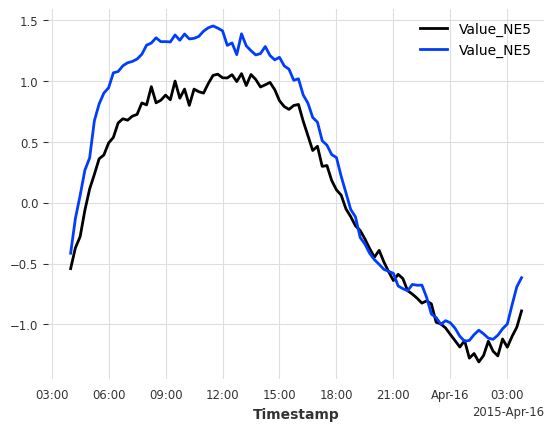

In [80]:
pred.plot()
target_long_scaled[10000 : 10000 + 4*24].plot()